Question: How do Spotify audio features differ between hit and non-hit songs, and how have these patterns changed over time?

In [2]:
import pandas as pd

file_path = "1950big_data.csv"
df = pd.read_csv(file_path, low_memory=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455908 entries, 0 to 455907
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   year                455908 non-null  int64  
 1   position            4028 non-null    float64
 2   title               455901 non-null  object 
 3   artist              4028 non-null    object 
 4   pos_sentiment       4028 non-null    float64
 5   neg_sentiment       4028 non-null    float64
 6   neut_sentiment      4028 non-null    float64
 7   compound_sentiment  4028 non-null    float64
 8   f_k_grade           4028 non-null    float64
 9   flesch_index        4028 non-null    float64
 10  fog_index           4028 non-null    float64
 11  num_syllables       4028 non-null    float64
 12  difficult_words     4028 non-null    float64
 13  num_dupes           4028 non-null    float64
 14  num_words           4028 non-null    float64
 15  num_lines           4028 non-null 

CLEANING DATA

In [3]:
audio_cols = [
    "danceability","energy","key","loudness","mode",
    "speechiness","acousticness","instrumentalness","liveness",
    "valence","tempo","time_signature"
]

other_numeric = [
    "position","popularity","duration_ms",
    "pos_sentiment","neg_sentiment","neut_sentiment","compound_sentiment",
    "f_k_grade","flesch_index","fog_index",
    "num_syllables","difficult_words","num_dupes","num_words","num_lines"
]

num_cols = [c for c in (audio_cols + other_numeric + ["year","hit","explicit"]) if c in df.columns]

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# hit -> 0/1 int
df["hit"] = df["hit"].astype(int)

df[num_cols].dtypes

danceability          float64
energy                float64
key                   float64
loudness              float64
mode                  float64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
time_signature        float64
position              float64
popularity            float64
duration_ms           float64
pos_sentiment         float64
neg_sentiment         float64
neut_sentiment        float64
compound_sentiment    float64
f_k_grade             float64
flesch_index          float64
fog_index             float64
num_syllables         float64
difficult_words       float64
num_dupes             float64
num_words             float64
num_lines             float64
year                    int64
hit                     int64
explicit              float64
dtype: object

In [6]:
# ALTERNATE CODE FOR DUPLICATE IDS THAT DOES NOT DROP THEM

import hashlib

# Identify IDs that map to multiple different songs (different positions)
duplicate_ids = df.groupby("id")["position"].nunique()
duplicate_ids = duplicate_ids[duplicate_ids > 1].index

# Display examples for documentation
print("Duplicate ID Examples:")
print("-" * 80)
examples = (df[df["id"].isin(duplicate_ids)]
           .sort_values(["id","year","title","artist","position"])
           [["id","year","title","artist","position"]]
           .drop_duplicates()
           .head(10))
print(examples.to_string(index=False))
print("-" * 80)

# Generate unique pseudo-IDs for duplicate entries
def generate_pseudo_id(row):
    """Create deterministic unique ID from song metadata."""
    components = [
        str(row.get('title', '')).strip().lower(),
        str(row.get('artists', '')).strip().lower(),
        str(row.get('year', '')),
        str(row.get('position', ''))
    ]
    id_string = '|'.join(components)
    return "dup" + hashlib.md5(id_string.encode()).hexdigest()

# Create clean dataset
df_clean = df.copy()

# Apply pseudo-IDs to duplicate entries
duplicate_mask = df_clean["id"].isin(duplicate_ids)
df_clean.loc[duplicate_mask, "id"] = df_clean.loc[duplicate_mask].apply(generate_pseudo_id, axis=1)

# Verify no duplicates remain
remaining_duplicates = (df_clean.groupby("id")["position"].nunique() > 1).sum()
print(f"\nDuplicate IDs resolved: {len(duplicate_ids)} → {remaining_duplicates}")
print(f"Dataset shape: {df.shape} → {df_clean.shape}")


Duplicate ID Examples:
--------------------------------------------------------------------------------
                    id  year          title          artist  position
1Gv6f7m5ZNDcInxGA8PsLS  1971      Superstar      Carpenters      30.0
1Gv6f7m5ZNDcInxGA8PsLS  1971      Superstar     Murray Head      27.0
2RChe0r2cMoyOvuKobZy44  1994         Always        Bon Jovi      91.0
2RChe0r2cMoyOvuKobZy44  1994         Always         Erasure      73.0
2bL2gyO6kBdLkNSkxXNh6x  2014        Animals        Maroon 5      62.0
2bL2gyO6kBdLkNSkxXNh6x  2014        Animals   Martin Garrix      71.0
4VZDv8sASBS8UruUBGTFdk  1990        Hold On        En Vogue       8.0
4VZDv8sASBS8UruUBGTFdk  1990        Hold On Wilson Phillips       1.0
5KG4OVGxSrFmNHGZBezJJn  1988 Don't Be Cruel     Bobby Brown      79.0
5KG4OVGxSrFmNHGZBezJJn  1988 Don't Be Cruel     Cheap Trick      70.0
--------------------------------------------------------------------------------

Duplicate IDs resolved: 5 → 0
Dataset shape:

In [4]:
# original duplicate ID resolution

bad_ids = df.groupby("id")["position"].nunique()
bad_ids = bad_ids[bad_ids > 1].index

(df[df["id"].isin(bad_ids)]
 .sort_values(["id","year","title","artist","position"])
 [["id","year","title","artist","position"]]
 .drop_duplicates())

,id,year,title,artist,position
817,1Gv6f7m5ZNDcInxGA8PsLS,1971,Superstar,Carpenters,30.0
816,1Gv6f7m5ZNDcInxGA8PsLS,1971,Superstar,Murray Head,27.0
2492,2RChe0r2cMoyOvuKobZy44,1994,Always,Bon Jovi,91.0
2478,2RChe0r2cMoyOvuKobZy44,1994,Always,Erasure,73.0
3924,2bL2gyO6kBdLkNSkxXNh6x,2014,Animals,Maroon 5,62.0
3932,2bL2gyO6kBdLkNSkxXNh6x,2014,Animals,Martin Garrix,71.0
2151,4VZDv8sASBS8UruUBGTFdk,1990,Hold On,En Vogue,8.0
2144,4VZDv8sASBS8UruUBGTFdk,1990,Hold On,Wilson Phillips,1.0
2059,5KG4OVGxSrFmNHGZBezJJn,1988,Don't Be Cruel,Bobby Brown,79.0
2050,5KG4OVGxSrFmNHGZBezJJn,1988,Don't Be Cruel,Cheap Trick,70.0


We removed a tiny number of ambiguous matches where a single id mapped to multiple distinct Billboard chart positions (5 cases), indicating likely title-based mismatches (e.g., same song title by different artists).

In [6]:
# original duplicate ID resolution

# delete those duplicate ids (10 over all)
df_clean = df[~df["id"].isin(bad_ids)].copy()

df.shape, df_clean.shape

((455908, 36), (455898, 36))

In [7]:
mask = df_clean["id"].isna()
key = (
    df_clean.loc[mask, "title"].fillna("").astype(str).str.strip().str.lower() + "|" +
    df_clean.loc[mask, "artists"].fillna("").astype(str).str.strip().str.lower() + "|" +
    df_clean.loc[mask, "year"].fillna("").astype(str).str.strip()
)

df_clean.loc[mask, "id"] = "missing_" + pd.util.hash_pandas_object(key, index=False).astype(str)

(df_clean.groupby("id")["position"].nunique() > 1).sum()
## Assign pseudo IDs to records with missing IDs.

np.int64(6)

In [8]:
df_clean = df_clean.sort_values(["id", "position"], ascending=[True, True])
df_clean = df_clean.drop_duplicates(subset=["id"], keep="first").copy()

(df_clean.groupby("id")["position"].nunique() > 1).sum()

## collapse multiple chart appearances of the same track to a single observation by keeping the best chart position

np.int64(0)

In [9]:
na_count = df_clean.isna().sum().sort_values(ascending=False)
na_percent = (na_count / len(df)).sort_values(ascending=False)
missing = pd.concat([na_count, na_percent], axis=1)
missing.columns = ["na_count", "na_percent"]
missing.head(20)

,na_count,na_percent
genre_tags,453230,0.994126
flesch_index,451880,0.991165
position,451880,0.991165
num_lines,451880,0.991165
num_words,451880,0.991165
num_dupes,451880,0.991165
difficult_words,451880,0.991165
fog_index,451880,0.991165
num_syllables,451880,0.991165
f_k_grade,451880,0.991165


A subset of variables exhibits extremely high levels of missingness, with more than 99% of observations missing. These variables share a common characteristic: they rely on external information sources beyond the core Spotify audio metadata. Specifically, this group includes genre-related information (genre_tags), lyric-based textual features (such as num_words, num_lines, num_syllables, f_k_grade, fog_index, flesch_index, and difficult_words), sentiment analysis scores (pos_sentiment, neg_sentiment, neut_sentiment, and compound_sentiment), as well as Billboard-specific metadata (artist and position).

The high missingness in these variables does not indicate data quality errors but rather reflects limited coverage from external data sources, including lyric databases, genre classification pipelines, and historical Billboard ranking records. Only a small subset of songs could be successfully matched to these auxiliary sources. Consequently, in a large-scale dataset comprising over 450,000 tracks, missingness exceeding 99% for these variables is an expected outcome of incomplete data integration rather than a result of incorrect data processing.

To mitigate potential bias and ensure robustness in exploratory analysis, these variables were retained in the raw dataset for documentation purposes but excluded from the primary analytical dataset used for exploratory data analysis and feature engineering.

In [10]:
print(df_clean[audio_cols ].isna().mean().sort_values(ascending=False))
print(df_clean[other_numeric].isna().mean().sort_values(ascending=False))

danceability        0.005541
energy              0.005541
key                 0.005541
loudness            0.005541
mode                0.005541
speechiness         0.005541
acousticness        0.005541
instrumentalness    0.005541
liveness            0.005541
valence             0.005541
tempo               0.005541
time_signature      0.005541
dtype: float64
position              0.991200
pos_sentiment         0.991200
neg_sentiment         0.991200
neut_sentiment        0.991200
compound_sentiment    0.991200
f_k_grade             0.991200
flesch_index          0.991200
fog_index             0.991200
num_syllables         0.991200
difficult_words       0.991200
num_dupes             0.991200
num_words             0.991200
num_lines             0.991200
popularity            0.005541
duration_ms           0.005541
dtype: float64


In [11]:
thr = 0.95
drop_cols = missing.index[missing["na_percent"] > thr].tolist()

analysis_df = df_clean.drop(columns=drop_cols)
print("analysis_df shape:", analysis_df.shape)
analysis_df.info()

analysis_df shape: (455892, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 455892 entries, 441956 to 1613
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              455892 non-null  int64  
 1   title             455885 non-null  object 
 2   id                455892 non-null  object 
 3   popularity        453366 non-null  float64
 4   duration_ms       453366 non-null  float64
 5   explicit          453366 non-null  float64
 6   artists           453366 non-null  object 
 7   id_artists        453366 non-null  object 
 8   danceability      453366 non-null  float64
 9   energy            453366 non-null  float64
 10  key               453366 non-null  float64
 11  loudness          453366 non-null  float64
 12  mode              453366 non-null  float64
 13  speechiness       453366 non-null  float64
 14  acousticness      453366 non-null  float64
 15  instrumentalness  453366 non-null  flo

In [12]:
analysis_df.isna().mean().sort_values(ascending=False).head(10)
# There is no severe or huge missing value

key                 0.005541
tempo               0.005541
liveness            0.005541
instrumentalness    0.005541
acousticness        0.005541
speechiness         0.005541
mode                0.005541
loudness            0.005541
energy              0.005541
danceability        0.005541
dtype: float64

Given the extremely low proportion of missing values and the absence of a clear, domain-justified similarity metric among songs, median imputation was chosen over KNN-based methods to avoid introducing unnecessary model-driven assumptions and potential noise.

More sophisticated imputation methods, such as KNN-based imputation, were considered but not adopted, as their assumptions were not aligned with the exploratory focus of this project.

In [13]:
num_cols = analysis_df.select_dtypes(include="number").columns
for c in num_cols:
     analysis_df[c] = analysis_df[c].fillna(analysis_df[c].median())
analysis_df.isna().sum()

year                   0
title                  7
id                     0
popularity             0
duration_ms            0
explicit               0
artists             2526
id_artists          2526
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
hit                    0
dtype: int64

In [14]:
df_clean[df_clean["id"].duplicated(keep=False)].sort_values("id")[["id","title","artist","year","hit"]].head(20)  #df[df.duplicated(subset=["title","year"], keep=False)].sort_values(["title","year"]).head(20)

,id,title,artist,year,hit


In [15]:
analysis_df.isna().sum()

year                   0
title                  7
id                     0
popularity             0
duration_ms            0
explicit               0
artists             2526
id_artists          2526
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
hit                    0
dtype: int64

A small number of missing values remain in identifier and textual fields such as title, artists, and id_artists. These variables serve as descriptive identifiers rather than analytical features. Since imputing such fields would introduce artificial or misleading information, missing values in these columns were retained and excluded from numerical preprocessing.

EDA

In [16]:
#Overview
analysis_df.shape

(455892, 21)

In [17]:
analysis_df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,455892.0,1988.785962,17.241922,1950.0,1976.0000,1991.000000,2003.00000,2015.000
popularity,455892.0,27.669746,15.954667,0.0,16.0000,27.000000,39.00000,90.000
duration_ms,455892.0,232958.874668,125537.780297,6373.0,176557.5000,220053.000000,268553.00000,5621218.000
explicit,455892.0,0.026903,0.161801,0.0,0.0000,0.000000,0.00000,1.000
danceability,455892.0,0.557693,0.162908,0.0,0.4500,0.571000,0.67700,0.991
energy,455892.0,0.548352,0.247619,0.0,0.3590,0.553000,0.75000,1.000
key,455892.0,5.212079,3.503280,0.0,2.0000,5.000000,8.00000,11.000
loudness,455892.0,-10.282313,4.925091,-60.0,-12.9020,-9.455000,-6.69600,5.376
mode,455892.0,0.668156,0.470876,0.0,0.0000,1.000000,1.00000,1.000
speechiness,455892.0,0.101214,0.181424,0.0,0.0333,0.042500,0.06900,0.971


The cleaned dataset contains 455892 unique Spotify ids from 1950 to 2015, each represented by core audio features and a binary indicator of Billboard hit status. Most audio variables fall within expected Spotify-defined ranges, with average danceability (0.56) and energy (0.55) indicating moderately rhythmic and energetic tracks overall. Loudness averages −10.28 dB, and the mean tempo is approximately 119 BPM, both consistent with mainstream popular music characteristics.

The majority of songs are in major mode (about 67%) and predominantly use a 4/4 time signature, suggesting limited variation in basic harmonic and rhythmic structure. Instrumentalness has a median near zero, indicating that most tracks contain vocals.

Notably, only about 0.88% of tracks are labeled as Billboard hits, revealing a highly imbalanced dataset. This imbalance is an important structural feature to consider in subsequent comparative analysis between hit and non-hit songs.

In [18]:
#Hit vs Non-hit
analysis_df.groupby("hit")[audio_cols].mean().T

hit,0,1
danceability,0.557431,0.587144
energy,0.548097,0.577090
key,5.213054,5.102193
loudness,-10.292477,-9.137570
mode,0.666177,0.891077
speechiness,0.101655,0.051499
acousticness,0.438745,0.364032
instrumentalness,0.095620,0.012339
liveness,0.217533,0.152310
valence,0.562470,0.588530


From the table, we can get hit songs tend to be more danceable, energetic, and louder than non-hit songs, while showing lower levels of acousticness and instrumentalness. In contrast, tonal attributes such as key and time signature exhibit minimal differences, suggesting that production intensity and rhythmic engagement play a stronger role in commercial success than basic harmonic structure.

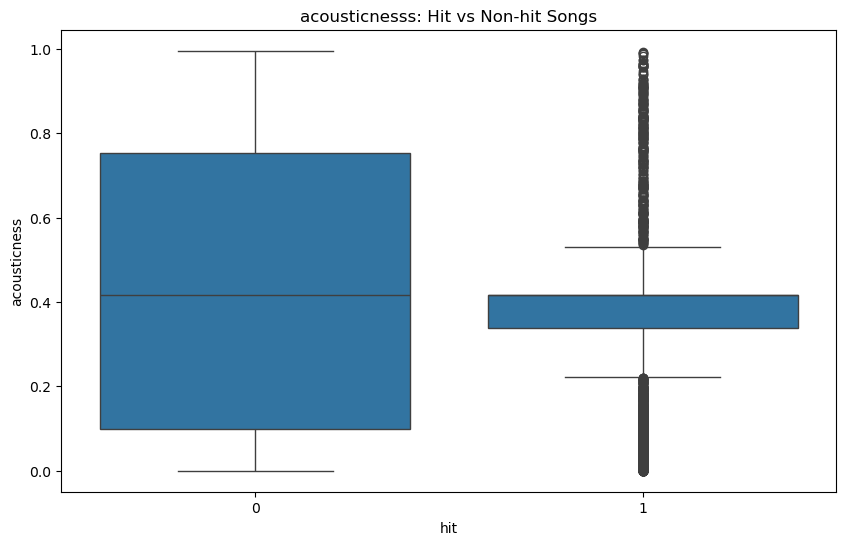

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=analysis_df,
    x="hit",
    y="acousticness"
)
plt.title("acousticnesss: Hit vs Non-hit Songs")
plt.show()

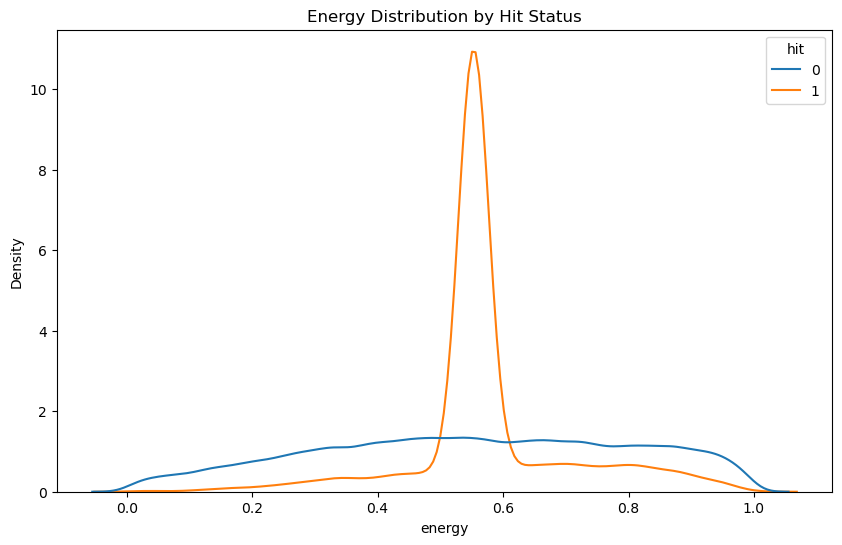

In [20]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=analysis_df,
    x="energy",
    hue="hit",
    common_norm=False
)
plt.title("Energy Distribution by Hit Status")
plt.show()

Hit songs show a more concentrated energy distribution around moderate values (approximately 0.5–0.6), while non-hit songs have a wider spread across the full range. This suggests that songs with moderate energy levels may be more likely to become hits.

EDA: Correlation

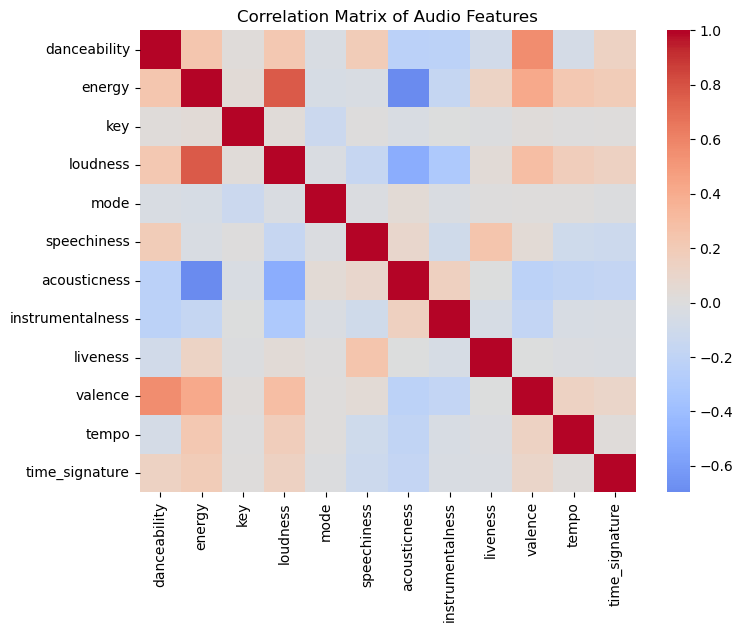

In [21]:
corr = analysis_df[audio_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Audio Features")
plt.show()

The correlation matrix reveals strong relationships among several production-related features. Energy is strongly positively correlated with loudness, while acousticness is negatively correlated with both energy and loudness, indicating that acoustic tracks tend to be softer and less intense. Danceability and valence also show a positive association, suggesting that rhythmically engaging songs are often perceived as more positive in mood.

EDA: Pattern Overtime

In [22]:
analysis_df["decade"] = (analysis_df["year"] // 10) * 10
hit_trend = (
    analysis_df[analysis_df["hit"] == 1]
    .groupby("decade")[audio_cols]
    .mean()
)

hit_trend.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
decade,,,,,,,,,,,,
1950,0.555694,0.516325,4.881279,-9.879790,0.990868,0.044375,0.502187,0.026897,0.147247,0.578599,117.848443,3.936073
1960,0.566763,0.530982,5.048170,-9.917033,0.909441,0.042866,0.448566,0.026020,0.157871,0.619297,117.666559,3.936416
1970,0.568126,0.555463,5.105754,-9.913065,0.894246,0.044691,0.397782,0.017132,0.155494,0.598507,118.305112,3.975117
1980,0.592379,0.578165,5.101987,-9.726383,0.919205,0.042262,0.357639,0.007068,0.142599,0.600492,118.027914,4.001325
1990,0.593226,0.579555,5.214393,-9.207525,0.899550,0.051355,0.339703,0.007050,0.152657,0.576545,116.496429,3.986507


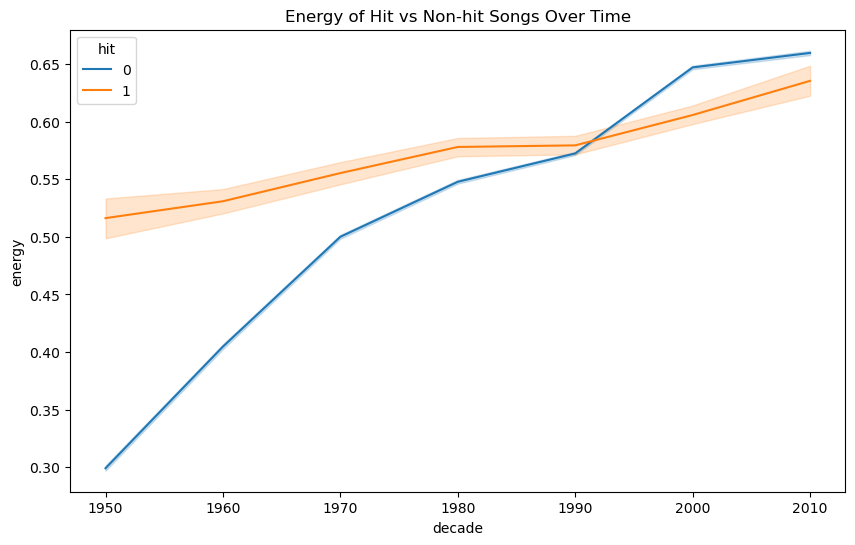

In [23]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data= analysis_df,
    x="decade",
    y="energy",
    hue="hit",
    estimator="mean"
)
plt.title("Energy of Hit vs Non-hit Songs Over Time")
plt.show()

Hit songs consistently have higher energy than non-hit songs in earlier decades, but the gap narrows over time as the energy of non-hit songs increases substantially. This suggests that overall song energy has increased across decades, and high energy is no longer a distinguishing characteristic unique to hit songs in recent years.

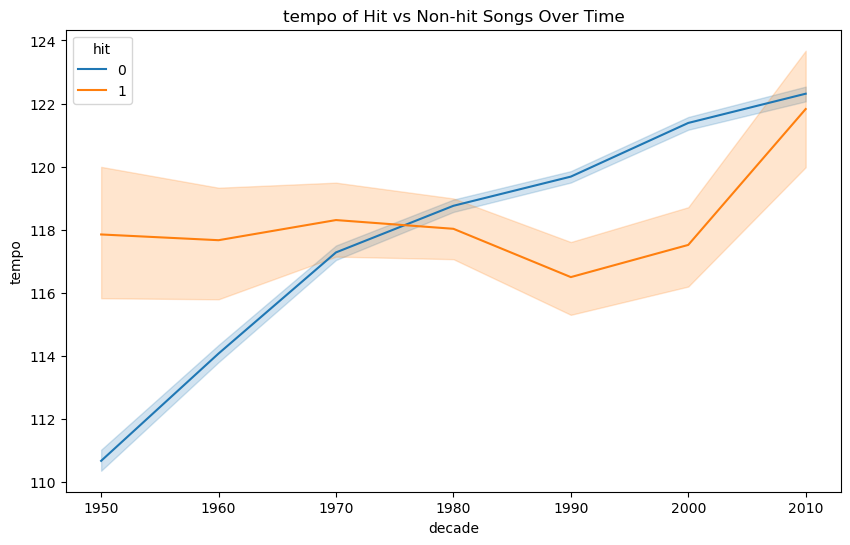

In [24]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data= analysis_df,
    x="decade",
    y="tempo",
    hue="hit",
    estimator="mean"
)
plt.title("tempo of Hit vs Non-hit Songs Over Time")
plt.show()

Tempo increases over time for both hit and non-hit songs, with non-hit songs showing a slightly stronger upward trend. This suggests that songs in general have become faster over the decades, but tempo alone does not clearly distinguish hit songs from non-hits.

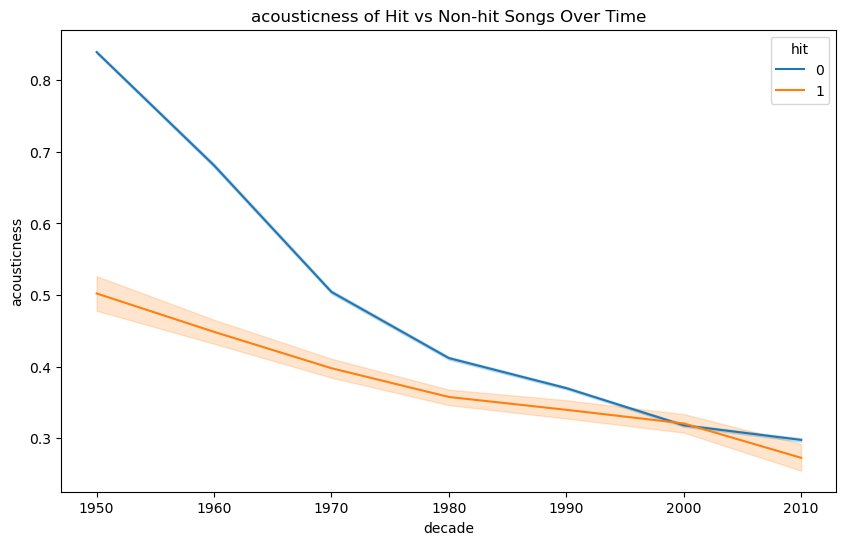

In [25]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data= analysis_df,
    x="decade",
    y="acousticness",
    hue="hit",
    estimator="mean"
)
plt.title("acousticness of Hit vs Non-hit Songs Over Time")
plt.show()

Acousticness decreases steadily over time for both hit and non-hit songs, indicating a shift away from acoustic sounds toward more electronic and produced music. The difference between hit and non-hit songs is relatively small, suggesting acousticness alone is not a strong distinguishing factor for song success.

In [26]:
analysis_df

,year,title,id,popularity,duration_ms,explicit,artists,id_artists,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,hit,decade
441956,2012,24.11.94 - Wersja Akustyczna,0004Uy71ku11n3LMpuyf59,34.0,258907.0,0.0,['Golden Life'],['3NyQ2NjqMjDtVSiEkXFW2r'],0.623,0.599,...,1.0,0.0255,0.1770,0.001480,0.0748,0.381,140.056,4.0,0,2010
231313,2005,Adam et Ève,000CSYu4rvd8cQ7JilfxhZ,43.0,189107.0,0.0,['Kaïn'],['1KMHmX2PgvEl1nFzFmEdcZ'],0.624,0.766,...,1.0,0.0731,0.3450,0.000000,0.1130,0.548,95.128,4.0,0,2000
448801,1977,Balla Trazan Apansson / Vegetarianvisan,000DsoWJKHdaUmhgcnpr8j,16.0,234533.0,0.0,['Trazan & Banarne'],['5PbCQPKjb0wQwaE7i5OVC6'],0.572,0.608,...,1.0,0.5550,0.6420,0.000220,0.3440,0.559,106.453,4.0,0,1970
100382,1978,Will Anything Happen,000G1xMMuwxNHmwVsBdtj1,32.0,182347.0,0.0,['Blondie'],['4tpUmLEVLCGFr93o8hFFIB'],0.256,0.895,...,1.0,0.0707,0.0131,0.000106,0.0821,0.555,191.307,4.0,0,1970
368382,2006,Podrás,000KblXP5csWFFFsD6smOy,35.0,240013.0,0.0,['Tamara Castro'],['11PnNvuse5a0xPupBIeHyW'],0.619,0.518,...,0.0,0.0534,0.8050,0.000000,0.1020,0.314,143.757,3.0,0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,1979,The Devil Went Down To Georgia,missing_9968343821017462301,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,1.0,0.0425,0.4160,0.000019,0.1400,0.577,117.397,4.0,1,1970
433,1964,Can't You See That She's Mine,missing_9972083696749178851,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,1.0,0.0425,0.4160,0.000019,0.1400,0.577,117.397,4.0,1,1960
1692,1984,Say Say Say,missing_9986834782371582784,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,1.0,0.0425,0.4160,0.000019,0.1400,0.577,117.397,4.0,1,1980
1752,1984,I'm So Excited,missing_9989049982824374491,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,1.0,0.0425,0.4160,0.000019,0.1400,0.577,117.397,4.0,1,1980


In [38]:
analysis_df["is_major"] = (analysis_df["mode"] == 1).astype(int)
# Creates a binary variable indicating whether a song is in a major key (1) or minor key (0), 
# transforming musical mode into a model-friendly categorical feature.

analysis_df.drop(columns=["mode"], inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
analysis_df[["energy_z","loudness_z","tempo_z"]] = scaler.fit_transform(
    analysis_df[["energy","loudness","tempo"]]
)

analysis_df["production_intensity"] = (
    analysis_df["energy_z"] +
    analysis_df["loudness_z"] +
    analysis_df["tempo_z"]
)
# Aggregates multiple production-related attributes into a composite index capturing overall sonic intensity.

In [ ]:
analysis_df["emotional_intensity"] = (
    analysis_df["valence"] * analysis_df["energy"]
)
# Captures emotional extremity rather than raw positivity.

In [ ]:
analysis_df["energy_decade_mean"] = analysis_df.groupby("decade")["energy"].transform("mean")
 
analysis_df["energy_relative"] = analysis_df["energy"] - analysis_df["energy_decade_mean"]
# Measures whether a song is more energetic relative to its contemporaries rather than in absolute terms.

In [39]:
analysis_df

,year,title,id,popularity,duration_ms,explicit,artists,id_artists,danceability,energy,...,time_signature,hit,decade,is_major,energy_z,loudness_z,tempo_z,production_intensity,energy_decade_mean,energy_relative
441956,2012,24.11.94 - Wersja Akustyczna,0004Uy71ku11n3LMpuyf59,34.0,258907.0,0.0,['Golden Life'],['3NyQ2NjqMjDtVSiEkXFW2r'],0.623,0.599,...,4.0,0,2010,1,0.204541,0.208588,0.724393,1.137522,0.659672,-0.060672
231313,2005,Adam et Ève,000CSYu4rvd8cQ7JilfxhZ,43.0,189107.0,0.0,['Kaïn'],['1KMHmX2PgvEl1nFzFmEdcZ'],0.624,0.766,...,4.0,0,2000,1,0.878965,0.491832,-0.797769,0.573027,0.646927,0.119073
448801,1977,Balla Trazan Apansson / Vegetarianvisan,000DsoWJKHdaUmhgcnpr8j,16.0,234533.0,0.0,['Trazan & Banarne'],['5PbCQPKjb0wQwaE7i5OVC6'],0.572,0.608,...,4.0,0,1970,1,0.240887,0.011840,-0.414078,-0.161351,0.500728,0.107272
100382,1978,Will Anything Happen,000G1xMMuwxNHmwVsBdtj1,32.0,182347.0,0.0,['Blondie'],['4tpUmLEVLCGFr93o8hFFIB'],0.256,0.895,...,4.0,0,1970,1,1.399927,1.100958,2.460779,4.961664,0.500728,0.394272
368382,2006,Podrás,000KblXP5csWFFFsD6smOy,35.0,240013.0,0.0,['Tamara Castro'],['11PnNvuse5a0xPupBIeHyW'],0.619,0.518,...,3.0,0,2000,0,-0.122575,0.992940,0.849783,1.720147,0.646927,-0.128927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,1979,The Devil Went Down To Georgia,missing_9968343821017462301,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,4.0,1,1970,1,0.018771,0.167979,-0.043295,0.143456,0.500728,0.052272
433,1964,Can't You See That She's Mine,missing_9972083696749178851,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,4.0,1,1960,1,0.018771,0.167979,-0.043295,0.143456,0.406185,0.146815
1692,1984,Say Say Say,missing_9986834782371582784,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,4.0,1,1980,1,0.018771,0.167979,-0.043295,0.143456,0.548191,0.004809
1752,1984,I'm So Excited,missing_9989049982824374491,27.0,220053.0,0.0,NaN,NaN,0.571,0.553,...,4.0,1,1980,1,0.018771,0.167979,-0.043295,0.143456,0.548191,0.004809


### Summary: This analysis reveals that hit songs tend to exhibit slightly higher danceability, energy, valence, and loudness compared to non-hit songs. While the absolute differences are moderate, patterns become more meaningful when examined relative to temporal context. For example, songs that are more energetic than the average of their decade show stronger associations with commercial success. Feature engineering further highlights that production intensity and emotional intensity may play a role in differentiating hit songs from non-hit songs. However, correlation analysis indicates that no single audio feature strongly determines hit status, suggesting that commercial success is influenced by multiple interacting factors rather than one dominant musical characteristic.

### Challenges Faced and Future Recommendations: Future work could focus on improving model performance under severe class imbalance by applying class weighting and carefully selecting evaluation metrics such as precision, recall, and F1-score rather than relying on accuracy alone. In addition, further refinement of feature engineering and systematic feature selection may help reduce redundancy and improve interpretability. Exploring alternative model specifications within familiar frameworks, such as regularized logistic regression, may also enhance predictive stability and generalization.